In [1]:
# Plotting U and wind shears from WACCM-X data

In [2]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


/tmp/ipykernel_140632/347690517.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# Plot Seasonal Averages (U and T)

In [3]:

ds_months_sets = [['06', '07', '08'], ['12', '01', '02']]
Monthstr_sets = [['Jun', 'Jul', 'Aug'], ['Dec', 'Jan', 'Feb']]
season_set = ['summer', 'winter']

run_name = 'Wuhu_IonTr_run'

plotdata = {}

for season_idx, months in enumerate(ds_months_sets):
    season_name = season_set[season_idx]
    Monthstr = Monthstr_sets[season_idx]
    
    file_paths = []
    for month in months:
        pattern = f'/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-*.nc'
        # Use glob to get all files matching the pattern
        file_paths.extend(glob.glob(pattern))
    
    # Open all files and concatenate along the time dimension
    ds = xr.open_mfdataset(file_paths, combine='by_coords')
    
    # Select only UT00:00 time steps
    dssel = ds.isel(time=slice(None, None, 24))

    #----------------------------------------------------
    # Extract  variables
    lon = dssel['lon']
    lat = dssel['lat']
    
    temp_dssel = dssel['T']
    U_dssel = dssel['U']
    
    # Average over time dimension
    Uav = U_dssel.mean(dim='time')
    Tav = temp_dssel.mean(dim='time')
    
    geopH = dssel['Z3'] / 1000  # m -> km
    
    # Calculate altitude from geopotential height
    Re = 6378  # Earth radius in km
    alt = (geopH * Re) / (Re - geopH)
    altav = alt.mean(dim='time')   
    
    # Define altitude slice range
    alt_min, alt_max = 90, 155  # km
    
    #----------------------------------------------------
    # Calculate local time offset in hours (assuming 15 degrees = 1 hour difference)
    local_time_offset = lon / 15.0  # Convert degrees to hours

    # UT hour
    snapshot_utc_time = 0  # hours

    # Convert UTC time (12:00) to local time for each longitude
    local_times = (snapshot_utc_time + local_time_offset) % 24
    #----------------------------------------------------

    # Loop over each latitude and process data
    for lat_val in [17.5, 47.5]:
        lat_idx = np.abs(lat - lat_val).argmin()
        
        #---------------------------------------------------------------------------
        altll = altav.sel(lat=lat[lat_idx]).mean(dim='lon')
        
        # alt_min_idx = np.abs(altll - alt_min).argmin().values
        # alt_max_idx = np.abs(altll - alt_max).argmin().values
        alt_min_idx = 60   
        alt_max_idx = 38 
    
        # Slice arrays using lev indices
        U_plot = Uav.sel(lat=lat[lat_idx]).isel(lev=slice(alt_max_idx, alt_min_idx + 1))
        T_plot = Tav.sel(lat=lat[lat_idx]).isel(lev=slice(alt_max_idx, alt_min_idx + 1))
        alt_plot = altll.isel(lev=slice(alt_max_idx, alt_min_idx + 1))
        
        # Store results in dictionary with appropriate keys
        plotdata[f'U_plot_{lat_val}_{season_name}'] = U_plot
        plotdata[f'T_plot_{lat_val}_{season_name}'] = T_plot
        plotdata[f'alt_plot_{lat_val}_{season_name}'] = alt_plot
        

print('done')
#print(plotdata.keys())  # Check keys in the dictionary

done


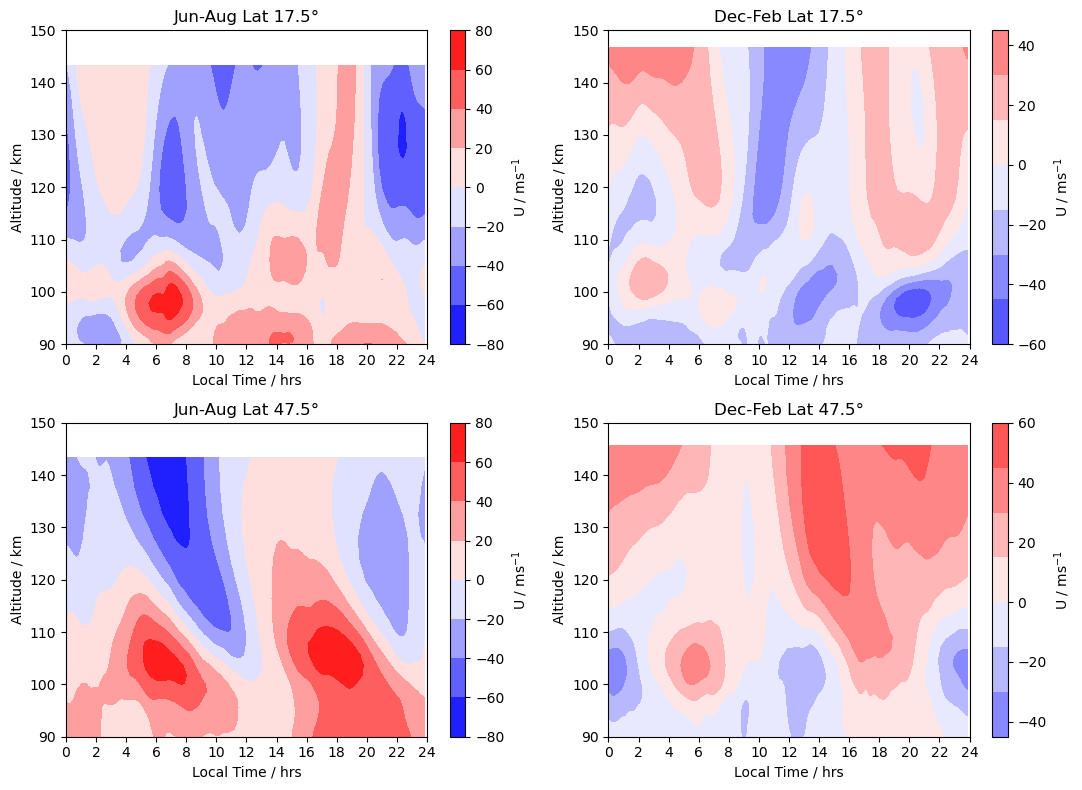

In [4]:
plot_data_U_summer = [plotdata['U_plot_17.5_summer'], plotdata['U_plot_47.5_summer']]
plot_data_U_winter = [plotdata['U_plot_17.5_winter'], plotdata['U_plot_47.5_winter']]

plot_data_alt_summer = [plotdata['alt_plot_17.5_summer'], plotdata['alt_plot_47.5_summer']]
plot_data_alt_winter = [plotdata['alt_plot_17.5_winter'], plotdata['alt_plot_47.5_winter']]


lat_vals = [17.5, 47.5]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))  # Adjust figsize as needed

# Loop over each latitude
for i, ax_row in enumerate(axes):
    lat_val = lat_vals[i]
    
    ax_s = axes[i, 0]

    # Plot U (wind) for summer in the first column
    contour_U_summer = ax_s.contourf(local_times, plot_data_alt_summer[i][::-1], plot_data_U_summer[i][::-1, :], cmap='bwr', vmin=-80, vmax=80)
    
    #cbar_U_summer = fig.colorbar(contour_U_summer, ax=ax_s, ticks=np.arange(-80, 81, 20))
    cbar_U_summer = fig.colorbar(contour_U_summer, ax=ax_s, orientation='vertical', ticks=np.linspace(-80, 80, 9))
    cbar_U_summer.set_label('U / ms$^{-1}$')
    
    ax_s.set_ylim(90, 150)
    ax_s.set_xlabel('Local Time / hrs')
    ax_s.set_ylabel('Altitude / km')
    ax_s.set_title(f'Jun-Aug Lat {lat_val}\u00b0')
    ax_s.set_xticks(np.linspace(0, 24, 13))
    
    ax_w = axes[i, 1]
    # Plot U (wind) for winter in the second column
    contour_U_winter = ax_w.contourf(local_times, plot_data_alt_winter[i][::-1], plot_data_U_winter[i][::-1, :], cmap='bwr', vmin=-80, vmax=80)

    #cbar_U_winter = fig.colorbar(contour_U_winter, ax=ax_w, ticks=np.arange(-80, 81, 20))
    cbar_U_winter = fig.colorbar(contour_U_winter, ax=ax_w, orientation='vertical', ticks=np.linspace(-80, 80, 9))
    cbar_U_winter.set_label('U / ms$^{-1}$')
    
    ax_w.set_ylim(90, 150)
    ax_w.set_xlabel('Local Time / hrs')
    ax_w.set_ylabel('Altitude / km')
    ax_w.set_title(f'Dec-Feb Lat {lat_val}\u00b0')
    ax_w.set_xticks(np.linspace(0, 24, 13))



# Adjust spacing between subplots
plt.tight_layout()

# Save figure
# figname = f'{run_name}_U_plot_altLT_lat_seasons.png'
# plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

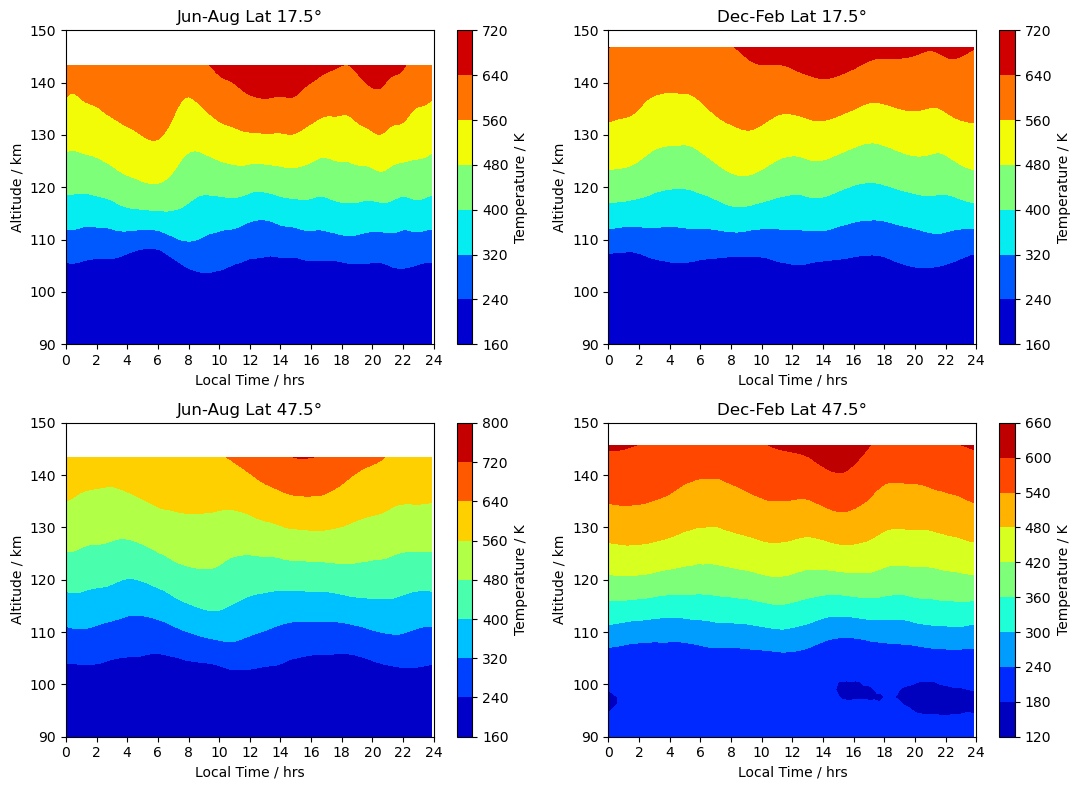

In [5]:
import matplotlib.colors as mcolors
plot_data_T_summer = [plotdata['T_plot_17.5_summer'], plotdata['T_plot_47.5_summer']]
plot_data_T_winter = [plotdata['T_plot_17.5_winter'], plotdata['T_plot_47.5_winter']]

plot_data_alt_summer = [plotdata['alt_plot_17.5_summer'], plotdata['alt_plot_47.5_summer']]
plot_data_alt_winter = [plotdata['alt_plot_17.5_winter'], plotdata['alt_plot_47.5_winter']]

lat_vals = [17.5, 47.5]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))  # Adjust figsize as needed

norm = mcolors.Normalize(vmin=160, vmax=800)

# Loop over each latitude
for i, ax_row in enumerate(axes):
    lat_val = lat_vals[i]
    
    ax_s = axes[i, 0]
    
    # Plot U (wind) for summer in the first column
    contour_U_summer = ax_s.contourf(local_times, plot_data_alt_summer[i][::-1], plot_data_T_summer[i][::-1, :], cmap='jet')
    cbar_U_summer = fig.colorbar(contour_U_summer, ax=ax_s)
    cbar_U_summer.set_label('Temperature / K')
    ax_s.set_ylim(90, 150)
    ax_s.set_xlabel('Local Time / hrs')
    ax_s.set_ylabel('Altitude / km')
    ax_s.set_title(f'Jun-Aug Lat {lat_val}\u00b0')
    ax_s.set_xticks(np.linspace(0, 24, 13))
    
    # Plot U (wind) for winter in the second column
    ax_w = axes[i, 1]
    contour_U_winter = ax_w.contourf(local_times, plot_data_alt_winter[i][::-1], plot_data_T_winter[i][::-1, :], cmap='jet')
    cbar_U_winter = fig.colorbar(contour_U_winter, ax=ax_w)
    cbar_U_winter.set_label('Temperature / K')
    ax_w.set_ylim(90, 150)
    ax_w.set_xlabel('Local Time / hrs')
    ax_w.set_ylabel('Altitude / km')
    ax_w.set_title(f'Dec-Feb Lat {lat_val}\u00b0')
    ax_w.set_xticks(np.linspace(0, 24, 13))

# Adjust spacing between subplots
plt.tight_layout()

# Save figure
figname = f'{run_name}_T_plot_altLT_lat_seasons.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

# Plot M+ and U timeseries

In [6]:
# Checking what altitudes indices 47 and 49 are

# lat_idx = np.abs(lat - 47.5).argmin()
# alt110 = altav.isel(lat=lat_idx).sel(lon=0)[48]
# alt110.values #110.631355

# alt113 = altav.isel(lat=lat_idx).sel(lon=0)[47]
# alt113.values #113.09447km

# alt108 = altav.isel(lat=lat_idx).sel(lon=0)[49]
# alt108.values #108.41612


In [7]:
import glob

# Winter data not importing correctly as it spans the end of the year
ds_months_sets = [['06', '07', '08'] ]#, ['12', '01', '02']]
Monthstr_sets = [['Jun', 'Jul', 'Aug'] ]#, ['Dec', 'Jan', 'Feb']]
season_set = ['summer']#, 'winter']
 

run_name = 'Wuhu_IonTr_run'

plotdata2 = {}

for season_idx, months in enumerate(ds_months_sets):
    season_name = season_set[season_idx]
    Monthstr = Monthstr_sets[season_idx]
    
    file_paths = []
    for month in months:
        pattern = f'/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-*.nc'
        # Use glob to get all files matching the pattern
        print(file_paths)
        file_paths.extend(glob.glob(pattern))
    
    ds = xr.open_mfdataset(file_paths, combine='by_coords')
    
    lon = ds['lon']
    lat = ds['lat']
    lev = ds['lev']
    temp = ds['T']
    timee = ds['time']   
    
    U = ds['U']

    Fep = ds['Fep']
    Mgp = ds['Mgp']
    Nap = ds['Nap']
    Mp = Fep + 2*Mgp + Nap
    Mpdens = ( Mp * 1e-6 * 100 * lev ) / (1.380503e-23 * temp)
    # print(Mpdens['time'][0].values)
    # print(Mpdens['time'][-1].values)
    #----------------------------------------------------

    for lat_val in [17.5, 47.5, 77.5]:
        lat_idx = np.abs(lat - lat_val).argmin()
        #print(f'lat_idx={lat_idx}')
        #print(lat[lat_idx].values)
        
        lon_val = 180
        lon_idx = np.abs(lon - lon_val).argmin()
        #print(f'lon_idx={lon_idx}')
        
        alt_110_idx = 48
        
        plotdata2[f'U_plot2_{lat_val}_{season_name}'] = U.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_110_idx)
        plotdata2[f'Mpdens_plot2_{lat_val}_{season_name}'] = Mpdens.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_110_idx)
        
        
        alt_113_idx = 47
        alt_108_idx = 49
        
        plotdata2[f'U_plot2_113_{lat_val}_{season_name}'] = U.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_113_idx)
        plotdata2[f'U_plot2_108_{lat_val}_{season_name}'] = U.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_108_idx)
        
        
        # alt_idx_120 = np.abs(altll - 120 ).argmin().values
        # alt_idx_100 = np.abs(altll - 100 ).argmin().values
        # print(f'lat={lat_val}, alt120ind={alt_idx_120}')  #45
        # print(f'lat={lat_val}, alt100ind={alt_idx_100}')  #53
        alt_120_idx = 45
        alt_100_idx = 53
        
        plotdata2[f'U_plot2_120_100_{lat_val}_{season_name}'] = ( (U.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_120_idx)) - (U.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_100_idx)) ) / 2e4   
                                            # wind shear is change in U / 20km   units = s-1
                        
        #---------------------------------------------------------------------------

print('done')
#print(plotdata.keys())  # Check keys in the dictionary

[]
['/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-15-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-09-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-06-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-30-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-27-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-23-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-06-04-00000.nc', '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX21

In [18]:
# PLOT JULY 47.5 lat

timestep1 = (30*24)

# Slice data for three different periods
Mpdens_plot_2_slice1 = plotdata2['Mpdens_plot2_47.5_summer'].isel(time=slice( timestep1, timestep1 + (10*24 + 1) )).values
U_plot_2_110_slice1 = plotdata2['U_plot2_47.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values
U_plot_2_113_slice1 = plotdata2['U_plot2_113_47.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values
U_plot_2_108_slice1 = plotdata2['U_plot2_108_47.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values

Mpdens_plot_2_slice2 = plotdata2['Mpdens_plot2_47.5_summer'].isel(time=slice(timestep1 + (10*24) , timestep1 + (20*24 + 1))).values
U_plot_2_110_slice2 = plotdata2['U_plot2_47.5_summer'].isel(time=slice(timestep1 + (10*24), timestep1 + (20*24 + 1))).values
U_plot_2_113_slice2 = plotdata2['U_plot2_113_47.5_summer'].isel(time=slice(timestep1 + (10*24), timestep1 + (20*24 + 1))).values
U_plot_2_108_slice2 = plotdata2['U_plot2_108_47.5_summer'].isel(time=slice(timestep1 + (10*24), timestep1 + (20*24 + 1))).values

Mpdens_plot_2_slice3 = plotdata2['Mpdens_plot2_47.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values
U_plot_2_110_slice3 = plotdata2['U_plot2_47.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values
U_plot_2_113_slice3 = plotdata2['U_plot2_113_47.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values
U_plot_2_108_slice3 = plotdata2['U_plot2_108_47.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values

time_array_sl1 = np.arange( 0, (10*24 + 1) ) / 24
time_array_sl2 = np.arange(10*24, (20*24 + 1) ) / 24
time_array_sl3 = np.arange(20*24, (30*24 + 1) ) / 24



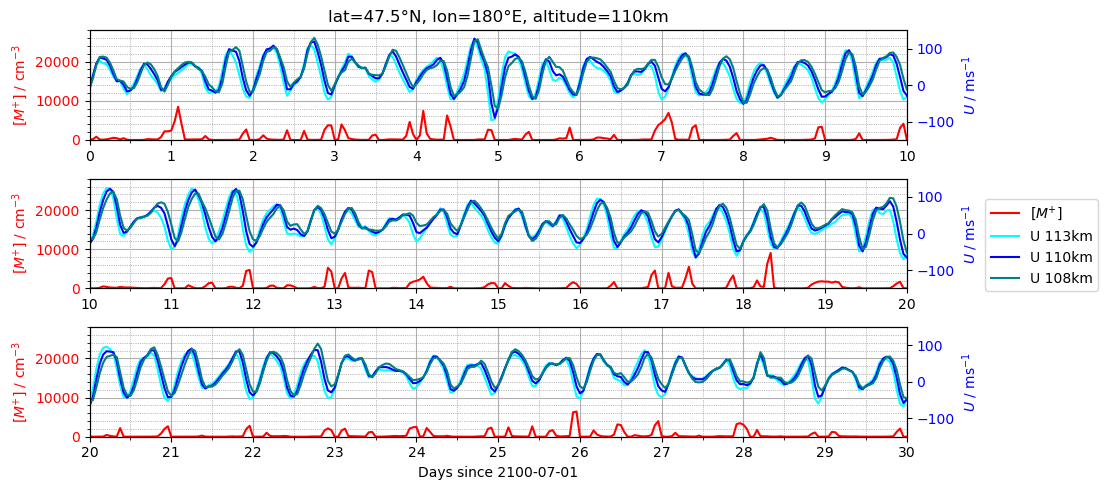

In [19]:
# PLOT JULY 47.5 lat

ylimMhigh = 2.8e4
ylimMlow = 0#-(ylimMhigh / 2)

Ulimhigh = 150
Ulimlow = -150

fig, axes = plt.subplots(nrows=3, figsize=(10, 5))

Mpcolour = 'red'
#------------------------------------------------------------------------------------------
axes[0].plot(time_array_sl1, Mpdens_plot_2_slice1, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[0].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[0].tick_params(axis='y', labelcolor=Mpcolour)
axes[0].set_ylim(ylimMlow, ylimMhigh)
axes[0].grid(True)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[0].set_xlim(0, 10)  
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1)) 
axes[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 
axes[0].set_title('lat=47.5\u00b0N, lon=180\u00b0E, altitude=110km')

axes0_right = axes[0].twinx()
axes0_right.plot(time_array_sl1, U_plot_2_113_slice1, color='cyan', label='U 113km')
axes0_right.plot(time_array_sl1, U_plot_2_110_slice1, color='blue', label='U 110km')
axes0_right.plot(time_array_sl1, U_plot_2_108_slice1, color='teal', label='U 108km')
axes0_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes0_right.tick_params(axis='y', labelcolor='blue')
axes0_right.set_ylim(Ulimlow, Ulimhigh)


#------------------------------------------------------------------------------------------
axes[1].plot(time_array_sl2, Mpdens_plot_2_slice2, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[1].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[1].tick_params(axis='y', labelcolor=Mpcolour)
axes[1].set_ylim(ylimMlow, ylimMhigh)
axes[1].grid(True)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[1].set_xlim(10, 20)  
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes1_right = axes[1].twinx()
axes1_right.plot(time_array_sl2, U_plot_2_113_slice2, color='cyan', label='U 113km')
axes1_right.plot(time_array_sl2, U_plot_2_110_slice2, color='blue', label='U 110km')
axes1_right.plot(time_array_sl2, U_plot_2_108_slice2, color='teal', label='U 108km')
axes1_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes1_right.tick_params(axis='y', labelcolor='blue')
axes1_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[2].plot(time_array_sl3, Mpdens_plot_2_slice3, color=Mpcolour, label=r'[$M$$^{+}$]') #
axes[2].set_xlabel('Days since 2100-07-01')
axes[2].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[2].tick_params(axis='y', labelcolor=Mpcolour)
axes[2].set_ylim(ylimMlow, ylimMhigh)
axes[2].grid(True)
axes[2].minorticks_on()
axes[2].xaxis.set_minor_locator(plt.MultipleLocator(0.5)) 
axes[2].set_xlim(20, 30)  
axes[2].xaxis.set_major_locator(plt.MultipleLocator(1))  
#axes[2].legend()
axes[2].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 


axes2_right = axes[2].twinx()
axes2_right.plot(time_array_sl3, U_plot_2_113_slice3, color='cyan', label='U 113km')
axes2_right.plot(time_array_sl3, U_plot_2_110_slice3, color='blue', label='U 110km')
axes2_right.plot(time_array_sl3, U_plot_2_108_slice3, color='teal', label='U 108km')
axes2_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes2_right.tick_params(axis='y', labelcolor='blue')
axes2_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
handles_right, labels_right = axes0_right.get_legend_handles_labels()

handles += handles_right
labels += labels_right

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.11, 0.5))

#------------------------------------------------------------------------------------------

plt.tight_layout()
figname = f'{run_name}_Mp_U_timeseries_Jul_lat47.5_110km_lon180_slices.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()

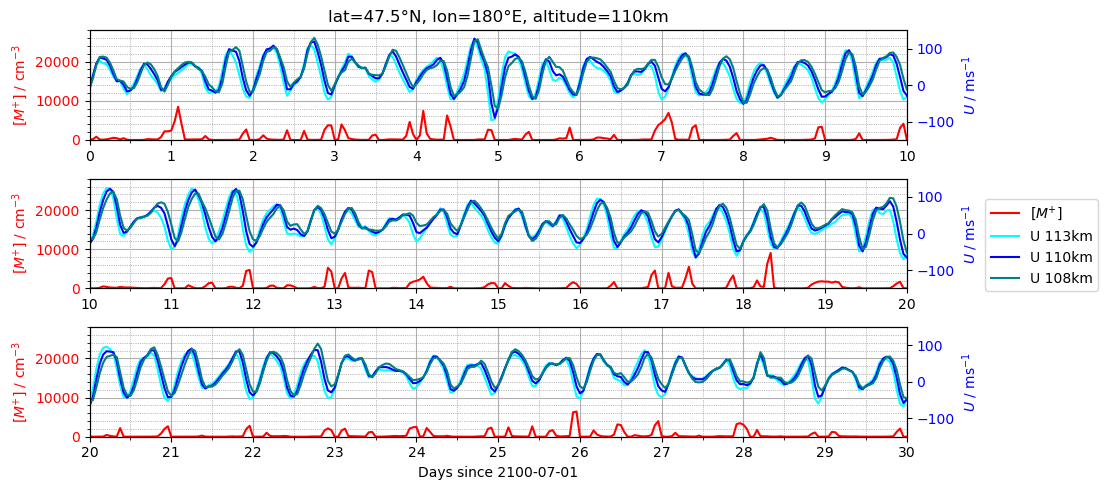

In [9]:
# PLOT JULY 47.5 lat

ylimMhigh = 2.8e4
ylimMlow = 0#-(ylimMhigh / 2)

Ulimhigh = 150
Ulimlow = -150

fig, axes = plt.subplots(nrows=3, figsize=(10, 5))

Mpcolour = 'red'
#------------------------------------------------------------------------------------------
axes[0].plot(time_array_sl1, Mpdens_plot_2_slice1, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[0].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[0].tick_params(axis='y', labelcolor=Mpcolour)
axes[0].set_ylim(ylimMlow, ylimMhigh)
axes[0].grid(True)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[0].set_xlim(0, 10)  
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1)) 
axes[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 
axes[0].set_title('lat=47.5\u00b0N, lon=180\u00b0E, altitude=110km')

axes0_right = axes[0].twinx()
axes0_right.plot(time_array_sl1, U_plot_2_113_slice1, color='cyan', label='U 113km')
axes0_right.plot(time_array_sl1, U_plot_2_110_slice1, color='blue', label='U 110km')
axes0_right.plot(time_array_sl1, U_plot_2_108_slice1, color='teal', label='U 108km')
axes0_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes0_right.tick_params(axis='y', labelcolor='blue')
axes0_right.set_ylim(Ulimlow, Ulimhigh)


#------------------------------------------------------------------------------------------
axes[1].plot(time_array_sl2, Mpdens_plot_2_slice2, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[1].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[1].tick_params(axis='y', labelcolor=Mpcolour)
axes[1].set_ylim(ylimMlow, ylimMhigh)
axes[1].grid(True)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[1].set_xlim(10, 20)  
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes1_right = axes[1].twinx()
axes1_right.plot(time_array_sl2, U_plot_2_113_slice2, color='cyan', label='U 113km')
axes1_right.plot(time_array_sl2, U_plot_2_110_slice2, color='blue', label='U 110km')
axes1_right.plot(time_array_sl2, U_plot_2_108_slice2, color='teal', label='U 108km')
axes1_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes1_right.tick_params(axis='y', labelcolor='blue')
axes1_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[2].plot(time_array_sl3, Mpdens_plot_2_slice3, color=Mpcolour, label=r'[$M$$^{+}$]') #
axes[2].set_xlabel('Days since 2100-07-01')
axes[2].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[2].tick_params(axis='y', labelcolor=Mpcolour)
axes[2].set_ylim(ylimMlow, ylimMhigh)
axes[2].grid(True)
axes[2].minorticks_on()
axes[2].xaxis.set_minor_locator(plt.MultipleLocator(0.5)) 
axes[2].set_xlim(20, 30)  
axes[2].xaxis.set_major_locator(plt.MultipleLocator(1))  
#axes[2].legend()
axes[2].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 


axes2_right = axes[2].twinx()
axes2_right.plot(time_array_sl3, U_plot_2_113_slice3, color='cyan', label='U 113km')
axes2_right.plot(time_array_sl3, U_plot_2_110_slice3, color='blue', label='U 110km')
axes2_right.plot(time_array_sl3, U_plot_2_108_slice3, color='teal', label='U 108km')
axes2_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes2_right.tick_params(axis='y', labelcolor='blue')
axes2_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
handles_right, labels_right = axes0_right.get_legend_handles_labels()

handles += handles_right
labels += labels_right

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.11, 0.5))

#------------------------------------------------------------------------------------------

plt.tight_layout()
figname = f'{run_name}_Mp_U_timeseries_Jul_lat47.5_110km_lon180_slices.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()

In [10]:
# PLOT JULY 17.5 lat

Mpdens_plot_2a_slice1 = plotdata2['Mpdens_plot2_17.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values
U_plot_2a_110_slice1 = plotdata2['U_plot2_17.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values 
U_plot_2a_113_slice1 = plotdata2['U_plot2_113_17.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values
U_plot_2a_108_slice1 = plotdata2['U_plot2_108_17.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values

Mpdens_plot_2a_slice2 = plotdata2['Mpdens_plot2_17.5_summer'].isel(time=slice(timestep1 + 10*24, timestep1 + (20*24 + 1))).values
U_plot_2a_110_slice2 = plotdata2['U_plot2_17.5_summer'].isel(time=slice(timestep1 + 10*24, timestep1 + (20*24 + 1))).values
U_plot_2a_113_slice2 = plotdata2['U_plot2_113_17.5_summer'].isel(time=slice(timestep1 + 10*24, timestep1 + (20*24 + 1))).values
U_plot_2a_108_slice2 = plotdata2['U_plot2_108_17.5_summer'].isel(time=slice(timestep1 + 10*24, timestep1 + (20*24 + 1))).values

Mpdens_plot_2a_slice3 = plotdata2['Mpdens_plot2_17.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values
U_plot_2a_110_slice3 = plotdata2['U_plot2_17.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values
U_plot_2a_113_slice3 = plotdata2['U_plot2_113_17.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values
U_plot_2a_108_slice3 = plotdata2['U_plot2_108_17.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values

time_array_sl1 = np.arange( 0, (10*24 + 1) ) / 24
time_array_sl2 = np.arange(10*24, (20*24 + 1) ) / 24
time_array_sl3 = np.arange(20*24, (30*24 + 1) ) / 24


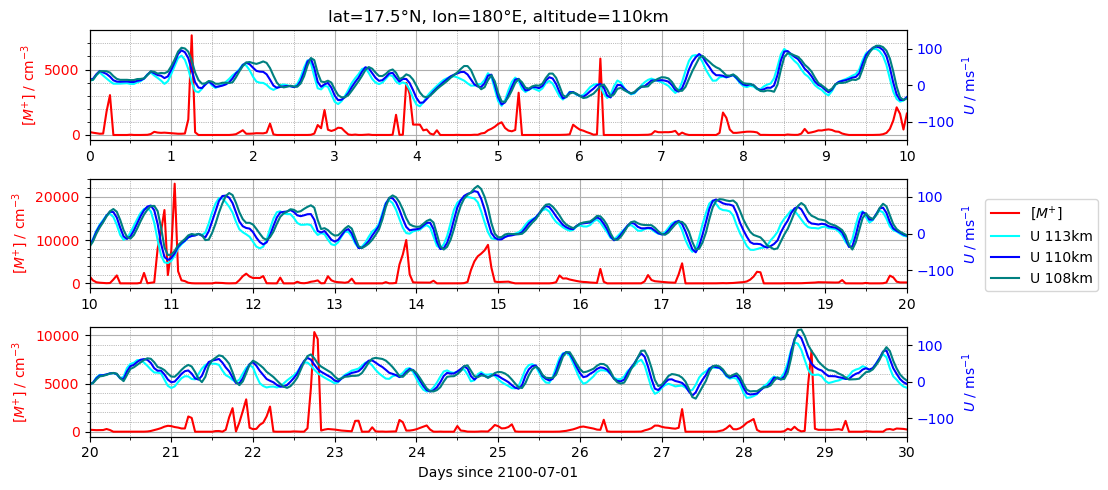

In [11]:
# PLOT JULY 17.5 lat

ylimMhigh = 2.8e4
ylimMlow = 0  

Ulimhigh = 150
Ulimlow = -150

fig, axes = plt.subplots(nrows=3, figsize=(10, 5))

Mpcolour = 'red'
#------------------------------------------------------------------------------------------
axes[0].plot(time_array_sl1, Mpdens_plot_2a_slice1, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[0].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[0].tick_params(axis='y', labelcolor=Mpcolour)
axes[0].grid(True)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[0].set_xlim(0, 10) 
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 
axes[0].set_title('lat=17.5\u00b0N, lon=180\u00b0E, altitude=110km')

axes0_right = axes[0].twinx()
axes0_right.plot(time_array_sl1, U_plot_2a_113_slice1, color='cyan', label='U 113km')
axes0_right.plot(time_array_sl1, U_plot_2a_110_slice1, color='blue', label='U 110km')
axes0_right.plot(time_array_sl1, U_plot_2a_108_slice1, color='teal', label='U 108km')
axes0_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes0_right.tick_params(axis='y', labelcolor='blue')
axes0_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[1].plot(time_array_sl2, Mpdens_plot_2a_slice2, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[1].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[1].tick_params(axis='y', labelcolor=Mpcolour)
axes[1].grid(True)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[1].set_xlim(10, 20) 
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes1_right = axes[1].twinx()
axes1_right.plot(time_array_sl2, U_plot_2a_113_slice2, color='cyan', label='U 113km')
axes1_right.plot(time_array_sl2, U_plot_2a_110_slice2, color='blue', label='U 110km')
axes1_right.plot(time_array_sl2, U_plot_2a_108_slice2, color='teal', label='U 108km')
axes1_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes1_right.tick_params(axis='y', labelcolor='blue')
axes1_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[2].plot(time_array_sl3, Mpdens_plot_2a_slice3, color=Mpcolour, label=r'[$M$$^{+}$]')
axes[2].set_xlabel('Days since 2100-07-01')
axes[2].set_ylabel(r'[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[2].tick_params(axis='y', labelcolor=Mpcolour)
axes[2].grid(True)
axes[2].minorticks_on()
axes[2].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[2].set_xlim(20, 30)  
axes[2].xaxis.set_major_locator(plt.MultipleLocator(1))  
#axes[2].legend()
axes[2].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes2_right = axes[2].twinx()
axes2_right.plot(time_array_sl3, U_plot_2a_113_slice3, color='cyan', label='U 113km')
axes2_right.plot(time_array_sl3, U_plot_2a_110_slice3, color='blue', label='U 110km')
axes2_right.plot(time_array_sl3, U_plot_2a_108_slice3, color='teal', label='U 108km')
axes2_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes2_right.tick_params(axis='y', labelcolor='blue')
axes2_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
handles_right, labels_right = axes0_right.get_legend_handles_labels()

handles += handles_right
labels += labels_right

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.11, 0.5))

#------------------------------------------------------------------------------------------

plt.tight_layout()
figname = f'{run_name}_Mp_U_timeseries_Jul_lat17.5_110km_lon180_slices.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()


In [12]:
# Combine separate U figures

from PIL import Image

img1 = 'Figures/Wuhu_IonTr_run/Winds/Wuhu_IonTr_run_Mp_U_timeseries_Jul_lat17.5_110km_lon180_slices.png' 
img2 = 'Figures/Wuhu_IonTr_run/Winds/Wuhu_IonTr_run_Mp_U_timeseries_Jul_lat47.5_110km_lon180_slices.png' 

image_paths = [img1, img2]
images = [Image.open(img) for img in image_paths]

widths, heights = zip(*(i.size for i in images))
max_width = max(widths)
total_height = sum(heights)

combined_image = Image.new('RGB', (max_width, total_height), color='white')

y_offset = 0
for image in images:
    combined_image.paste(image, (0, y_offset))
    y_offset += image.size[1]

combined_image.save('Figures/Wuhu_IonTr_run/Winds/Wuhu_IonTr_run_Mp_U_timeseries_Jul_lat47.5_17.5_110km_lon180_slices.png')  # Save the combined image


In [13]:
#==========================================================================
# SAME PLOTS BUT U AS WIND SHEAR 120-100km
#==========================================================================

In [14]:
timestep1 = (30*24)

time_array_sl1 = np.arange( 0, (10*24 + 1) ) / 24
time_array_sl2 = np.arange(10*24, (20*24 + 1) ) / 24
time_array_sl3 = np.arange(20*24, (30*24 + 1) ) / 24


Mpdens_plot_2_slice1 = plotdata2['Mpdens_plot2_47.5_summer'].isel(time=slice( timestep1, timestep1 + (10*24 + 1) )).values
Mpdens_plot_2_slice2 = plotdata2['Mpdens_plot2_47.5_summer'].isel(time=slice(timestep1 + (10*24) , timestep1 + (20*24 + 1))).values
Mpdens_plot_2_slice3 = plotdata2['Mpdens_plot2_47.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values

U_plot_2_120_100_slice1 = plotdata2['U_plot2_120_100_47.5_summer'].isel(time=slice( timestep1, timestep1 + (10*24 + 1) )).values
U_plot_2_120_100_slice2 = plotdata2['U_plot2_120_100_47.5_summer'].isel(time=slice(timestep1 + (10*24) , timestep1 + (20*24 + 1))).values
U_plot_2_120_100_slice3 = plotdata2['U_plot2_120_100_47.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values

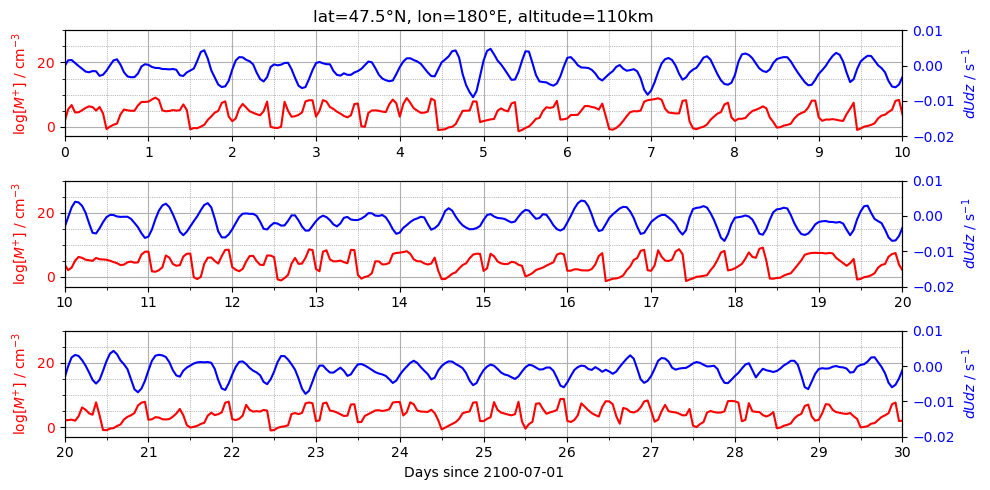

In [15]:
# PLOT JULY 47.5 lat U gradient

# ylimMhigh = 2.8e4
# ylimMlow = 0

ylimMhigh = 30
ylimMlow = -3

Ulimhigh = 0.01
Ulimlow = -0.02

fig, axes = plt.subplots(nrows=3, figsize=(10, 5))

Mpcolour = 'red'
#------------------------------------------------------------------------------------------
axes[0].plot(time_array_sl1, np.log(Mpdens_plot_2_slice1), color=Mpcolour, label=r'log[$M$$^{+}$]')
axes[0].set_ylabel(r'log[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[0].tick_params(axis='y', labelcolor=Mpcolour)
axes[0].set_ylim(ylimMlow, ylimMhigh)
axes[0].grid(True)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[0].set_xlim(0, 10)  
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 
axes[0].set_title('lat=47.5\u00b0N, lon=180\u00b0E, altitude=110km')

axes0_right = axes[0].twinx()
axes0_right.plot(time_array_sl1, U_plot_2_120_100_slice1, color='blue', label=r'dUdz$_{120-100km}$')

axes0_right.set_ylabel(r'$dUdz$ / s$^{-1}$', color='blue')
axes0_right.tick_params(axis='y', labelcolor='blue')
axes0_right.set_ylim(Ulimlow, Ulimhigh)


#------------------------------------------------------------------------------------------
axes[1].plot(time_array_sl2, np.log(Mpdens_plot_2_slice2), color=Mpcolour, label=r'log[$M$$^{+}$]')
axes[1].set_ylabel(r'log[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[1].tick_params(axis='y', labelcolor=Mpcolour)
axes[1].set_ylim(ylimMlow, ylimMhigh)
axes[1].grid(True)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[1].set_xlim(10, 20) 
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 


axes1_right = axes[1].twinx()
axes1_right.plot(time_array_sl2, U_plot_2_120_100_slice2, color='blue', label=r'dUdz$_{120-100km}$')

axes1_right.set_ylabel(r'$dUdz$ / s$^{-1}$', color='blue')
axes1_right.tick_params(axis='y', labelcolor='blue')
axes1_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[2].plot(time_array_sl3, np.log(Mpdens_plot_2_slice3), color=Mpcolour, label=r'log[$M$$^{+}$]') #
axes[2].set_xlabel('Days since 2100-07-01')
axes[2].set_ylabel(r'log[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[2].tick_params(axis='y', labelcolor=Mpcolour)
axes[2].set_ylim(ylimMlow, ylimMhigh)
axes[2].grid(True)
axes[2].minorticks_on()
axes[2].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[2].set_xlim(20, 30) 
axes[2].xaxis.set_major_locator(plt.MultipleLocator(1))  
#axes[2].legend()
axes[2].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 


axes2_right = axes[2].twinx()
axes2_right.plot(time_array_sl3, U_plot_2_120_100_slice3, color='blue', label=r'dUdz$_{120-100km}$')

axes2_right.set_ylabel(r'$dUdz$ / s$^{-1}$', color='blue')
axes2_right.tick_params(axis='y', labelcolor='blue')
axes2_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
handles_right, labels_right = axes0_right.get_legend_handles_labels()

handles += handles_right
labels += labels_right

#------------------------------------------------------------------------------------------

plt.tight_layout()
figname = f'{run_name}_Mp_Ugrad_timeseries_Jul_lat47.5_110km_lon180_slices.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()

In [16]:
Mpdens_plot_2a_slice1 = plotdata2['Mpdens_plot2_17.5_summer'].isel(time=slice(timestep1, timestep1 + (10*24 + 1))).values
Mpdens_plot_2a_slice2 = plotdata2['Mpdens_plot2_17.5_summer'].isel(time=slice(timestep1 + 10*24, timestep1 + (20*24 + 1))).values
Mpdens_plot_2a_slice3 = plotdata2['Mpdens_plot2_17.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values

U_plot_2a_120_100_slice1 = plotdata2['U_plot2_120_100_17.5_summer'].isel(time=slice( timestep1, timestep1 + (10*24 + 1) )).values
U_plot_2a_120_100_slice2 = plotdata2['U_plot2_120_100_17.5_summer'].isel(time=slice(timestep1 + (10*24) , timestep1 + (20*24 + 1))).values
U_plot_2a_120_100_slice3 = plotdata2['U_plot2_120_100_17.5_summer'].isel(time=slice(timestep1 + 20*24, timestep1 + (30*24 + 1))).values

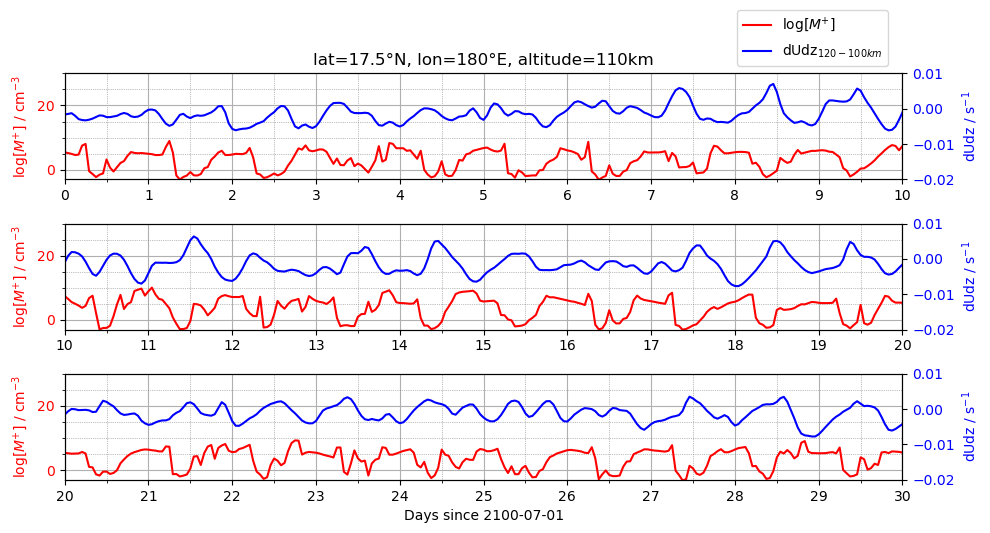

In [17]:
# PLOT JULY 17.5 lat U gradient

ylimMhigh = 30
ylimMlow = -3

Ulimhigh = 0.01
Ulimlow = -0.02

fig, axes = plt.subplots(nrows=3, figsize=(10, 5))

Mpcolour = 'red'
#------------------------------------------------------------------------------------------
axes[0].plot(time_array_sl1, np.log(Mpdens_plot_2a_slice1), color=Mpcolour, label=r'log[$M$$^{+}$]')
axes[0].set_ylabel(r'log[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[0].tick_params(axis='y', labelcolor=Mpcolour)
axes[0].set_ylim(ylimMlow, ylimMhigh)
axes[0].grid(True)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[0].set_xlim(0, 10)  
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 
axes[0].set_title('lat=17.5\u00b0N, lon=180\u00b0E, altitude=110km')

axes0_right = axes[0].twinx()
axes0_right.plot(time_array_sl1, U_plot_2a_120_100_slice1, color='blue', label=r'dUdz$_{120-100km}$')

axes0_right.set_ylabel(r'dUdz / s$^{-1}$', color='blue')
axes0_right.tick_params(axis='y', labelcolor='blue')
axes0_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[1].plot(time_array_sl2, np.log(Mpdens_plot_2a_slice2), color=Mpcolour, label=r'log[$M$$^{+}$]')
axes[1].set_ylabel(r'log[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[1].tick_params(axis='y', labelcolor=Mpcolour)
axes[1].set_ylim(ylimMlow, ylimMhigh)
axes[1].grid(True)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))
axes[1].set_xlim(10, 20) 
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes1_right = axes[1].twinx()
axes1_right.plot(time_array_sl2, U_plot_2a_120_100_slice2, color='blue', label=r'dUdz$_{120km-100km}$')

axes1_right.set_ylabel(r'dUdz / s$^{-1}$', color='blue')
axes1_right.tick_params(axis='y', labelcolor='blue')
axes1_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
axes[2].plot(time_array_sl3, np.log(Mpdens_plot_2a_slice3), color=Mpcolour, label=r'log[$M$$^{+}$]')
axes[2].set_xlabel('Days since 2100-07-01')
axes[2].set_ylabel(r'log[$M$$^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[2].tick_params(axis='y', labelcolor=Mpcolour)
axes[2].set_ylim(ylimMlow, ylimMhigh)
axes[2].grid(True)
axes[2].minorticks_on()
axes[2].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[2].set_xlim(20, 30)  
axes[2].xaxis.set_major_locator(plt.MultipleLocator(1))  
#axes[2].legend()
axes[2].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes2_right = axes[2].twinx()
axes2_right.plot(time_array_sl3, U_plot_2a_120_100_slice3, color='blue', label=r'dUdz$_{120km-100km}$')

axes2_right.set_ylabel(r'dUdz / s$^{-1}$', color='blue')
axes2_right.tick_params(axis='y', labelcolor='blue')
axes2_right.set_ylim(Ulimlow, Ulimhigh)

#------------------------------------------------------------------------------------------
handles, labels = axes[0].get_legend_handles_labels()
handles_right, labels_right = axes0_right.get_legend_handles_labels()

handles += handles_right
labels += labels_right

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 1.07))#1.15, 0.5))

#------------------------------------------------------------------------------------------

plt.tight_layout()
figname = f'{run_name}_Mp_Ugrad_timeseries_Jul_lat17.5_110km_lon180_slices.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()


In [12]:
# Combine U gradient figures

from PIL import Image

img1 = 'Figures/Wuhu_IonTr_run/Winds/Wuhu_IonTr_run_Mp_Ugrad_timeseries_Jul_lat17.5_110km_lon180_slices.png' 
img2 = 'Figures/Wuhu_IonTr_run/Winds/Wuhu_IonTr_run_Mp_Ugrad_timeseries_Jul_lat47.5_110km_lon180_slices.png' 

image_paths = [img1, img2]
images = [Image.open(img) for img in image_paths]

widths, heights = zip(*(i.size for i in images))
max_width = max(widths)
total_height = sum(heights)

combined_image = Image.new('RGB', (max_width, total_height), color='white')

y_offset = 0
for image in images:
    combined_image.paste(image, (0, y_offset))
    y_offset += image.size[1]

combined_image.save('Figures/Wuhu_IonTr_run/Winds/Wuhu_IonTr_run_Mp_log_Ugrad_timeseries_Jul_lat47.5_17.5_110km_lon180_slices.png')  # Save the combined image


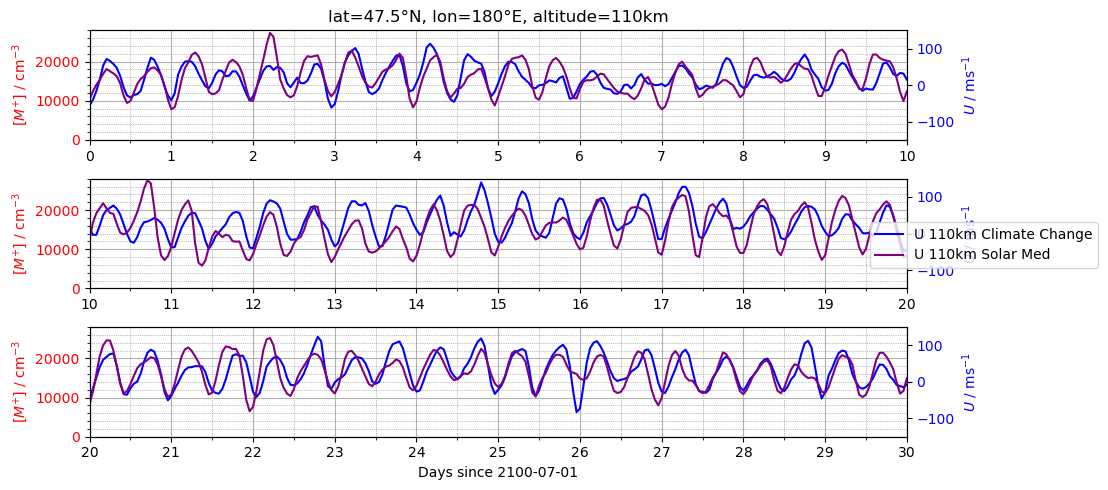

In [26]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import glob

# File patterns for each climate run
base_pattern_run1 = '/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{}-*.nc'
base_pattern_run2 = '/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{}-*.nc' 

# Months to process
months = ['06', '07', '08']
lat_val = 47.5
lon_val = 180
alt_110_idx = 48

def process_climate_run(base_pattern, months):
    """Extract time-series data for the given file pattern and months."""
    plotdata = {'Mpdens': [], 'U': []}
    
    for month in months:
        file_pattern = base_pattern.format(month)
        file_paths = glob.glob(file_pattern)
        
        if not file_paths:
            print(f"No files found for month {month}")
            continue

        ds = xr.open_mfdataset(file_paths, combine='by_coords')
        lon = ds['lon']
        lat = ds['lat']
        lev = ds['lev']
        temp = ds['T']
        U = ds['U']

        Fep = ds['Fep']
        Mgp = ds['Mgp']
        Nap = ds['Nap']
        Mp = Fep + 2 * Mgp + Nap
        Mpdens = (Mp * 1e-6 * 100 * lev) / (1.380503e-23 * temp)

        # Find nearest grid points
        lat_idx = np.abs(lat - lat_val).argmin()
        lon_idx = np.abs(lon - lon_val).argmin()

        # Append time-series data
        plotdata['Mpdens'].extend(Mpdens.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_110_idx).values)
        plotdata['U'].extend(U.sel(lat=lat[lat_idx], lon=lon[lon_idx]).isel(lev=alt_110_idx).values)
    
    return plotdata

# Process both climate runs
plotdata_run1 = process_climate_run(base_pattern_run1, months)
plotdata_run2 = process_climate_run(base_pattern_run2, months)

# Slice data for different periods (similar to your example)
timestep1 = (30 * 24)

# Define the time arrays for slices
time_array_sl1 = np.arange(0, (10 * 24 + 1)) / 24
time_array_sl2 = np.arange(10 * 24, (20 * 24 + 1)) / 24
time_array_sl3 = np.arange(20 * 24, (30 * 24 + 1)) / 24

# Example of slicing the data from plotdata_run1 (this would be the same for plotdata_run2)
# Adjust to match your dataset naming and structure.
import matplotlib.pyplot as plt
import numpy as np

# Data (Placeholder for the actual data loading)
# plotdata_run1 and plotdata_run2 should already be defined, containing the respective data

# Define your time slices (10 days per slice)
time_array_sl1 = np.arange(0, (10 * 24 + 1)) / 24
time_array_sl2 = np.arange(10 * 24, (20 * 24 + 1)) / 24
time_array_sl3 = np.arange(20 * 24, (30 * 24 + 1)) / 24

# Extract data for both runs (run1 and run2)
Mpdens_plot_1_slice1 = plotdata_run1['Mpdens'][:10*24+1]
U_plot_1_110_slice1 = plotdata_run1['U'][:10*24+1]

Mpdens_plot_1_slice2 = plotdata_run1['Mpdens'][10*24:20*24+1]
U_plot_1_110_slice2 = plotdata_run1['U'][10*24:20*24+1]

Mpdens_plot_1_slice3 = plotdata_run1['Mpdens'][20*24:30*24+1]
U_plot_1_110_slice3 = plotdata_run1['U'][20*24:30*24+1]

Mpdens_plot_2_slice1 = plotdata_run2['Mpdens'][:10*24+1]
U_plot_2_110_slice1 = plotdata_run2['U'][:10*24+1]

Mpdens_plot_2_slice2 = plotdata_run2['Mpdens'][10*24:20*24+1]
U_plot_2_110_slice2 = plotdata_run2['U'][10*24:20*24+1]

Mpdens_plot_2_slice3 = plotdata_run2['Mpdens'][20*24:30*24+1]
U_plot_2_110_slice3 = plotdata_run2['U'][20*24:30*24+1]

# Set up the plot limits
ylimMhigh = 2.8e4
ylimMlow = 0  # -(ylimMhigh / 2)

Ulimhigh = 150
Ulimlow = -150

# Create the figure with 3 subplots
fig, axes = plt.subplots(nrows=3, figsize=(10, 5))

# Plot for the first slice (time 0-10 days)
Mpcolour = 'red'
# axes[0].plot(time_array_sl1, Mpdens_plot_1_slice1, color=Mpcolour, label=r'[$M^{+}$] Run 1')
# axes[0].plot(time_array_sl1, Mpdens_plot_2_slice1, color='green', label=r'[$M^{+}$] Run 2')
axes[0].set_ylabel(r'[$M^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[0].tick_params(axis='y', labelcolor=Mpcolour)
axes[0].set_ylim(ylimMlow, ylimMhigh)
axes[0].grid(True)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[0].set_xlim(0, 10)  
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1)) 
axes[0].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 
axes[0].set_title('lat=47.5\u00b0N, lon=180\u00b0E, altitude=110km')

axes0_right = axes[0].twinx()
axes0_right.plot(time_array_sl1, U_plot_1_110_slice1, color='blue', label='U 110km Climate Change')
axes0_right.plot(time_array_sl1, U_plot_2_110_slice1, color='purple', label='U 110km Solar Med')
axes0_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes0_right.tick_params(axis='y', labelcolor='blue')
axes0_right.set_ylim(Ulimlow, Ulimhigh)

# Plot for the second slice (time 10-20 days)
# axes[1].plot(time_array_sl2, Mpdens_plot_1_slice2, color=Mpcolour, label=r'[$M^{+}$] Run 1')
# axes[1].plot(time_array_sl2, Mpdens_plot_2_slice2, color='green', label=r'[$M^{+}$] Run 2')
axes[1].set_ylabel(r'[$M^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[1].tick_params(axis='y', labelcolor=Mpcolour)
axes[1].set_ylim(ylimMlow, ylimMhigh)
axes[1].grid(True)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  
axes[1].set_xlim(10, 20)  
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[1].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes1_right = axes[1].twinx()
axes1_right.plot(time_array_sl2, U_plot_1_110_slice2, color='blue', label='U 110km Climate Change')
axes1_right.plot(time_array_sl2, U_plot_2_110_slice2, color='purple', label='U 110km Solar Med')
axes1_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes1_right.tick_params(axis='y', labelcolor='blue')
axes1_right.set_ylim(Ulimlow, Ulimhigh)

# Plot for the third slice (time 20-30 days)
# axes[2].plot(time_array_sl3, Mpdens_plot_1_slice3, color=Mpcolour, label=r'[$M^{+}$] Run 1')
# axes[2].plot(time_array_sl3, Mpdens_plot_2_slice3, color='green', label=r'[$M^{+}$] Run 2')
axes[2].set_xlabel('Days since 2100-07-01')
axes[2].set_ylabel(r'[$M^{+}$] / cm$^{-3}$', color=Mpcolour)
axes[2].tick_params(axis='y', labelcolor=Mpcolour)
axes[2].set_ylim(ylimMlow, ylimMhigh)
axes[2].grid(True)
axes[2].minorticks_on()
axes[2].xaxis.set_minor_locator(plt.MultipleLocator(0.5)) 
axes[2].set_xlim(20, 30)  
axes[2].xaxis.set_major_locator(plt.MultipleLocator(1))  
axes[2].grid(which='minor', color='gray', linestyle=':', linewidth=0.5) 

axes2_right = axes[2].twinx()
axes2_right.plot(time_array_sl3, U_plot_1_110_slice3, color='blue', label='U 110km Climate Change')
axes2_right.plot(time_array_sl3, U_plot_2_110_slice3, color='purple', label='U 110km Solar Med')
axes2_right.set_ylabel(r'$U$ / ms$^{-1}$', color='blue')
axes2_right.tick_params(axis='y', labelcolor='blue')
axes2_right.set_ylim(Ulimlow, Ulimhigh)

# Combine all legends
handles, labels = axes[0].get_legend_handles_labels()
handles_right, labels_right = axes0_right.get_legend_handles_labels()

handles += handles_right
labels += labels_right

fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.11, 0.5))

# Save the plot
plt.tight_layout()
figname = f'Climate_Run1_and_Run2_Mp_U_timeseries_Jul_lat47.5_110km_lon180_slices.png'
plt.savefig('Figures/Wuhu_IonTr_run/Winds/' + str(figname), dpi=400, bbox_inches='tight')
plt.show()
